<a href="https://colab.research.google.com/github/mzdwedar/python-data-analysis/blob/main/tmdb_500/tmdb_5000_movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


## Get the data from kaggle

In [1]:
! pip install -q kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=917416fb033253d342c5e4e4084d7f54a7d5e1dd7911756d2892d7ebb1b487e2
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
! kaggle  datasets download -d datasets tmdb/tmdb-movie-metadata

  0% 0.00/8.89M [00:00<?, ?B/s]
100% 8.89M/8.89M [00:00<00:00, 143MB/s]


In [5]:
! unzip tmdb-movie-metadata.zip

Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


## Data Wrangling


*   Missing Values
*   Choose appropriate dtypes



In [12]:
tmdb = pd.read_csv('tmdb_5000_movies.csv')

In [13]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [14]:
tmdb.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [15]:
def clean_data(tmdb):
  return (
      tmdb
      .assign(
        homepage = tmdb.homepage.fillna('<unk>'),
        overview = tmdb.overview.fillna('<unk>'),
        runtime = tmdb.runtime.fillna(tmdb.runtime.mean()),
        tagline = tmdb.tagline.fillna('<unk>')
      )
      .astype({'id':'int32', 'release_date':'datetime64', 'runtime':'int16', 'status':'category', 
                    'vote_average':'float32', 'vote_count':'int16'}, errors='ignore')
  )

## Analysis

**Statistical summary of the numerical columns**


In [17]:
numerical_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

tmdb[numerical_cols].agg(['mean', 'std', 'min', 'max'])

,budget,popularity,revenue,runtime,vote_average,vote_count
mean,2.904504e+07,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


**Average rate of the years 2000, 2001, 2002, 2003**

In [29]:
cleaned_tmdb = clean_data(tmdb)

mask = clean_data(tmdb).release_date.dt.year.isin([2000, 2001, 2002, 2003])


(cleaned_tmdb[mask]
 .groupby(cleaned_tmdb[mask].release_date.dt.year)
 .vote_average
 .mean())

release_date
2000    5.956024
2001    6.046995
2002    6.096552
2003    6.012426
Name: vote_average, dtype: float32

**Rearange the dataframe based on revenue - budget values**

In [ ]:
cleaned_tmdb.iloc[(cleaned_tmdb.revenue  - cleaned_tmdb.budget).sort_values().index]

**Allocate the year with the largest movies released in  ['Action', 'Romance']**

1.   Extract 'name' from json objects
2.   Filter the records of two genres (action, romance)
3.   Groupby (release_year and genre)








In [ ]:
import json 
from itertools import chain

def extract_genre(genres):
  new_vals = []
  for item in json.loads(genres):
    new_vals.append(item['name'])

  return new_vals

def filter_action_romance(genre):
  return genre['genres'].isin(['Action', 'Romance'])

def apply_mask(mask, tmdb):
  return tmdb_genres[mask]

genres = cleaned_tmdb['genres'].apply(extract_genre)

tmdb_genres = pd.DataFrame({
    'genres' : list(chain.from_iterable(genres.tolist())), 
    # 'title' : tmdb.original_title.repeat(genres.str.len()),
    'release_year' : cleaned_tmdb.release_date.repeat(genres.str.len())
})

(tmdb_genres
 .pipe(filter_action_romance)
 .pipe(apply_mask, tmdb_genres)
).reset_index(drop=True).groupby([tmdb_genres.release_year.dt.year, 'genres'], sort=False)

**Find the movies with top 5 revenue - budget value**

In [ ]:
top_5_mask = (cleaned_tmdb.revenue  - cleaned_tmdb.budget).sort_values(ascending=False).index[:5]
cleaned_tmdb.iloc[top_5_mask]

**The year with the highest number of movies release**

In [38]:
(cleaned_tmdb
 .groupby(cleaned_tmdb.release_date.dt.year)
 .original_title
 .count()
 .sort_values(ascending=False)
 .index[0]
 )

2009.0

**The top 2 countries with the highest production movies number**

In [39]:
def extract_countries(countries):
  new_vals = []
  for item in json.loads(countries):
    new_vals.append(item['name'])

  return new_vals

countries = cleaned_tmdb['production_countries'].apply(extract_countries)

pd.DataFrame({
    'countries' : list(chain.from_iterable(countries.tolist())), 
    'title' : cleaned_tmdb.original_title.repeat(countries.str.len())
}).groupby('countries').agg(total_movies = ('title', 'count')).sort_values(by='total_movies', ascending=False).iloc[:2]

,total_movies
countries,
United States of America,3956
United Kingdom,636


**The top 1 company with the highest production movies number**

In [40]:
def extract_companies(companies):
  new_vals = []
  for item in json.loads(companies):
    new_vals.append(item['name'])

  return new_vals

companies = cleaned_tmdb['production_companies'].apply(extract_companies)

pd.DataFrame({
    'companies' : list(chain.from_iterable(companies.tolist())), 
    'title' : cleaned_tmdb.original_title.repeat(companies.str.len())
}).groupby('companies').agg(total_movies = ('title', 'count')).sort_values(by='total_movies', ascending=False).iloc[0]

total_movies    319
Name: Warner Bros., dtype: int64

**Is there any relation between the runtime and average vote value**

Text(0.5, 1.0, 'corr: 0.3750456803651881')

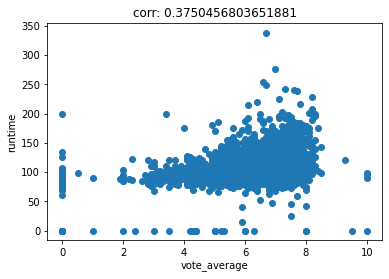

In [41]:
pearson = tmdb['runtime'].corr(tmdb['vote_average'])

plt.scatter(data=tmdb, y='runtime', x='vote_average')
plt.xlabel('vote_average')
plt.ylabel('runtime')
plt.title(f'corr: {pearson}')

# The linear coorelation is weak !

**The most unsuccessful movie along time in terms of revenue - budget**

In [42]:
lowest_profit_mask = (cleaned_tmdb.revenue  - cleaned_tmdb.budget).sort_values().index[0]
cleaned_tmdb.iloc[lowest_profit_mask]

budget                                                          255000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                            http://disney.go.com/the-lone-ranger/
id                                                                  57201
keywords                [{"id": 1556, "name": "texas"}, {"id": 2673, "...
original_language                                                      en
original_title                                            The Lone Ranger
overview                The Texas Rangers chase down a gang of outlaws...
popularity                                                      49.046956
production_companies    [{"name": "Walt Disney Pictures", "id": 2}, {"...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                          2013-07-03 00:00:00
revenue                                                          89289910
runtime                               

**The top 5 successful years for the USA cinema based on the total income devided by number of movies**

In [43]:
from itertools import chain

countries = cleaned_tmdb['production_countries'].apply(extract_countries)

def filter_usa(df):
  return df['countries'].isin(['United States of America'])

def apply_mask(mask, tmdb_countries):
  return tmdb_countries[mask][['revenue', 'release_year']]

def groupby_year(df):
  return df.groupby(df.release_year.dt.year).agg(['sum', 'count'])

def compute_metric(df):
  return df.revenue['sum'] / df.revenue['count']

tmdb_usa = pd.DataFrame({
    'countries' : list(chain.from_iterable(countries.tolist())), 
    'revenue' : cleaned_tmdb.revenue.repeat(countries.str.len()),
    'release_year': cleaned_tmdb.release_date.repeat(countries.str.len()),
})

(tmdb_usa
 .pipe(filter_usa)
 .pipe(apply_mask, tmdb_usa)
 .pipe(groupby_year)
 .pipe(compute_metric)
 ).sort_values(ascending=False).iloc[:5]

release_year
2016    1.603217e+08
1975    1.519088e+08
1939    1.478438e+08
2012    1.398315e+08
1942    1.389548e+08
dtype: float64

**Find the most succesfull movie in [USA, UK]**

In [44]:
from itertools import chain

countries = cleaned_tmdb['production_countries'].apply(extract_countries)

def filter_usa_uk(df):
  return df['countries'].isin(['United States of America', 'United Kingdom'])

def apply_mask(mask, tmdb_countries):
  return tmdb_countries[mask]

#  **assuming successfull == revenue**
tmdb_countries = pd.DataFrame({
    'countries' : list(chain.from_iterable(countries.tolist())), 
    'revenue' : cleaned_tmdb.revenue.repeat(countries.str.len()),
    'title':cleaned_tmdb.original_title.repeat(countries.str.len())
})

(tmdb_countries
 .pipe(filter_usa_uk)
 .pipe(apply_mask, tmdb_countries)
 ).groupby(['countries', 'title']).max('revenue').sort_values(by='revenue', ascending=False).iloc[:2]

,,revenue
countries,title,
United States of America,Avatar,2787965087
United Kingdom,Avatar,2787965087
